## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Кондратьев |
|---------|--------|
| Группа  | 6      |

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from abc import ABC, abstractmethod
from time import time
import pickle
import gzip

## Фреймворк

Базовые абстрактные классы слоев. Класс *Layer* используется для передаточных функций и функций ошибок. Класс *WeightLayer* - для линейного слоя.

In [4]:
class Layer(ABC):
    def __init__(self):
        self.idx = 0
    
    @abstractmethod
    def forward(self, x):
        pass
    
    @abstractmethod
    def backward(self, dx):
        pass
    
class WeightLayer(Layer):
    @abstractmethod
    def update(self, lr):
        pass

Линейный слой

In [5]:
class Linear(WeightLayer):
    def __init__(self, nin, nout):
        super(Linear).__init__()
        self.W = np.random.normal(0, 1.0 / np.sqrt(2 * nin), (nout, nin))
        self.b = np.zeros((1, nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def forward(self, x):
        self.x = x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self, lr, optim, test=False):
        dW, db = optim.update(self.idx, lr, self.dW, self.db)
        self.W += dW
        self.b += db

Функция Softmax

In [6]:
class Softmax(Layer):
    def forward(self, z):
        self.z = z
        zmax = z.max(axis=1, keepdims=True)
        expz = np.exp(z - zmax)
        Z = expz.sum(axis=1, keepdims=True)
        return expz / Z
    
    def backward(self, dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)

Функции потерь: CrossEntropyLoss, квадратичная ошибка

In [7]:
class CrossEntropyLoss(Layer):
    def forward(self, p, y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()
    
    def backward(self, loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0 / len(self.y)
        return dlog_softmax / self.p
    
class MeanSquareLoss(Layer):
    def forward(self, p, y):
        self.p = p
        self.y = np.zeros_like(p)
        for i, j in enumerate(y):
            self.y[i, j] = 1
        return np.sum((self.y - self.p) ** 2)
    
    def backward(self, loss):
        return 2 * (self.p - self.y)

Передаточные функции: гиперболический тангенс, ReLU, сигмоида, softplus.

In [8]:
class Tanh(Layer):
    def forward(self, x):
        self.y = np.tanh(x)
        return self.y
    
    def backward(self, dy):
        return (1.0 - self.y ** 2) * dy
    
class ReLU(Layer):
    def forward(self, x):
        self.y = np.maximum(x, np.zeros(x.shape))
        return self.y
    
    def backward(self, dy):
        self.y[self.y > 0] = 1
        return self.y * dy
    
class Sigmoid(Layer):
    def forward(self, x):
        self.y = 1 / (1 + np.exp(-x))
        return self.y
    
    def backward(self, dy):
        return self.y * (1 - self.y) * dy
    
class SoftPlus(Layer):
    def forward(self, x):
        self.x = x
        return np.log(1 + np.exp(x))
    
    def backward(self, dy):
        return 1 / (1 + np.exp(-self.x)) * dy

Оптимизаторы: градиентный спуск, ипульсный градиентный спуск, Adagrad, RMSProp

In [9]:
class GD:
    """Gradient Descent"""
    def __init__(self):
        self.net = None
    
    def init(self, idx):
        pass
    
    def update(self, idx, lr, dW, db):
        return (-lr * dW, -lr * db)
    
    def clear(self):
        pass

class NAG:
    """Nesterov Accelerated Gradient"""
    def __init__(self, beta=0.9):
        self.net = None
        self.beta = beta
        self.vdw = dict()
        self.vdb = dict()
        
    def init(self, idx):
        self.vdw[idx] = np.zeros_like(self.net.layers[idx].W)
        self.vdb[idx] = np.zeros_like(self.net.layers[idx].b)
        
    def update(self, idx, lr, dW, db, test=False):
        if not test:
            self.vdw[idx] = self.beta * self.vdw[idx] + (1 - self.beta) * dW
            self.vdb[idx] = self.beta * self.vdb[idx] + (1 - self.beta) * db
        return (-lr * self.vdw[idx], -lr * self.vdb[idx])
    
    def clear(self):
        for v in self.vdw.values():
            v.fill(0)
        for v in self.vdb.values():
            v.fill(0)

class Adagrad:
    def __init__(self, eps=1e-6):
        self.net = None
        self.eps = eps
        self.Gw = dict()
        self.Gb = dict()
        
    def init(self, idx):
        self.Gw[idx] = np.zeros_like(self.net.layers[idx].W)
        self.Gb[idx] = np.zeros_like(self.net.layers[idx].b)
        
    def update(self, idx, lr, dW, db, test=False):
        if not test:
            self.Gw[idx] += dW ** 2
            self.Gb[idx] += db ** 2
            
        return (-lr / ((self.Gw[idx] + self.eps) ** 0.5) * dW, -lr / ((self.Gb[idx] + self.eps) ** 0.5) * db)
    
    def clear(self):
        for v in self.Gw.values():
            v.fill(0)
        for v in self.Gb.values():
            v.fill(0)

class RMSProp:
    def __init__(self, beta=0.9, eps=1e-6):
        self.net = None
        self.beta = beta
        self.eps = eps
        self.Ew = dict()
        self.Eb = dict()
        
    def init(self, idx):
        self.Ew[idx] = np.zeros_like(self.net.layers[idx].W)
        self.Eb[idx] = np.zeros_like(self.net.layers[idx].b)
        
    def update(self, idx, lr, dW, db, test=False):
        if not test:
            self.Ew[idx] = self.beta * self.Ew[idx] + (1 - self.beta) * dW ** 2
            self.Eb[idx] = self.beta * self.Eb[idx] + (1 - self.beta) * db ** 2
            
        return (-lr / ((self.Ew[idx] + self.eps) ** 0.5) * dW, -lr / ((self.Eb[idx] + self.eps) ** 0.5) * db)
    
    def clear(self):
        for v in self.Ew.values():
            v.fill(0)
        for v in self.Eb.values():
            v.fill(0)

Класс сети. Принимает функцию потерь и оптимизатор.

В обучении оптимизатор используется или напрямую, или с наилучшим шагом, выбранным при помощи тернарного поиска.

In [10]:
class Net:    
    def __init__(self, loss, optimizer, adaptive_lr=False):
        self.layers = []
        self.loss = loss
        self.optimizer = optimizer
        self.optimizer.net = self
        self.adaptive_lr = adaptive_lr
    
    def add(self, *args):
        prev = 0 if len(self.layers) == 0 else self.layers[-1].idx
        for i in range(len(args)):
            self.layers.append(args[i])
            self.layers[-1].idx = prev + i
            if isinstance(self.layers[-1], WeightLayer):
                self.optimizer.init(prev + i)
        
    def forward(self, x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self, z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def train_epoch(self, train_x, train_labels, batch_size, lr):
        for i in range(0, len(train_x), batch_size):
            xb = train_x[i:i+batch_size]
            yb = train_labels[i:i+batch_size]
            
            p = self.forward(xb)
            l = self.loss.forward(p, yb)
            dp = self.loss.backward(l)
            dx = self.backward(dp)
            
            if self.adaptive_lr:
                l = 1e-6
                r = 500
                while r - l > 1e-6:
                    a = l + (r - l) / 3
                    b = l + 2 * (r - l) / 3
                    
                    self.update(a * lr, True)
                    loss_a = self.get_loss(xb, yb)
                    self.update(-a * lr, True)
                    
                    self.update(b * lr, True)
                    loss_b = self.get_loss(xb, yb)
                    self.update(-b * lr, True)
                    
                    if loss_a < loss_b:
                        r = b
                    else:
                        l = a
                self.update(l * lr)
            else:
                self.update(lr)
                
    def get_confusion_matrix(self, x, y):
        p = np.argmax(self.forward(x), axis=1)
        n = np.unique(y).shape[0]
        cm = np.zeros((n, n))
        for a, b in zip(p, y):
            if a != b:
                cm[a, b] += 1
            cm[b, a] += 1
        return cm
    
    def get_loss(self, x, y):
        p = self.forward(x)
        l = self.loss.forward(p, y)
        return l
    
    def get_acc(self, x, y):
        p = self.forward(x)
        pred = np.argmax(p, axis=1)
        acc = (pred == y).mean()
        return acc
    
    def get_loss_acc(self, x, y):
        p = self.forward(x)
        l = self.loss.forward(p, y)
        pred = np.argmax(p, axis=1)
        acc = (pred == y).mean()
        return l, acc
    
    def update(self, lr, test=False):
        self.optimizer.clear()
        for l in self.layers:
            if isinstance(l, WeightLayer):
                l.update(lr, self.optimizer, test)

Функция обучения нескольких эпох и вывод результатов

In [11]:
def train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size, lr, steps, debug=False):
    print("Initial loss={:.4f}, accuracy={:.4f}".format(*net.get_loss_acc(train_data, train_labels)))
    
    # accuracy = [[net.get_acc(train_data, train_labels)], [net.get_acc(test_data, test_labels)]]
    start = time()
    accuracy = [[], []]
    for i in range(steps):
        net.train_epoch(train_data, train_labels, batch_size, lr)
        train_acc = net.get_acc(train_data, train_labels)
        
        if debug: print(f"Epoch {i+1}: accuracy={train_acc:.4f}")
        accuracy[0].append(train_acc)
        accuracy[1].append(net.get_acc(test_data, test_labels))
    end = time()
    
    print("Final loss={:.4f}, accuracy={:.4f}".format(*net.get_loss_acc(train_data, train_labels)))
    print("Test loss={:.4f}, accuracy={:.4f}".format(*net.get_loss_acc(test_data, test_labels)))
    print("Elapsed time: {:.2f}s".format(end - start))
    
    figure = plt.figure(figsize=(15, 4))
    axes = figure.add_subplot(1, 2, 1)
    plt.xticks([])
    plt.yticks([])
    matr = axes.imshow(net.get_confusion_matrix(test_data, test_labels))
    figure.colorbar(matr)
    axes = figure.add_subplot(1, 2, 2)
    plt.xticks(range(1, steps+1))
    plt.plot(range(1, steps+1), accuracy[0], 'k--')
    plt.plot(range(1, steps+1), accuracy[1], 'g-')
    plt.show()

## MNIST

In [12]:
!curl -o mnist.pkl.gz https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
!gzip -d mnist.pkl.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9.9M  100  9.9M    0     0  21.8M      0 --:--:-- --:--:-- --:--:-- 21.8M


In [13]:
with open('mnist.pkl','rb') as f:
    MNIST = pickle.load(f)

train_data, test_data, train_labels, test_labels = train_test_split(MNIST['Train']['Features'], MNIST['Train']['Labels'], train_size=0.8)
print(train_data.shape, test_data.shape)

(33600, 784) (8400, 784)


### Однослойная сеть

Самый стандартный вариант

Initial loss=88.5656, accuracy=0.0894
Final loss=3.2236, accuracy=0.8542
Test loss=3.4456, accuracy=0.8488
Elapsed time: 11.75s


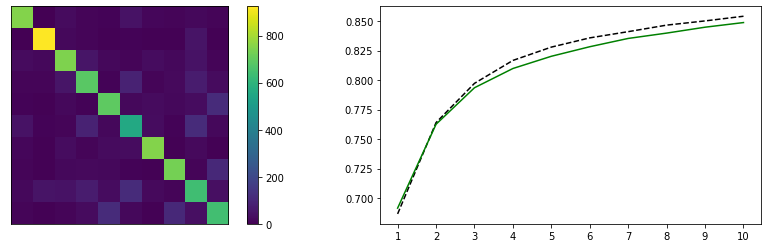

In [14]:
net = Net(loss=CrossEntropyLoss(), optimizer=GD())
net.add(
    Linear(784, 10),
    Softmax()
)

train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.00001, steps=10)

Использование наискорейшего градиентного спуска дает прирост точности, но увеличивает время обучения

Initial loss=95.7695, accuracy=0.0783
Final loss=1.2249, accuracy=0.8992
Test loss=1.6361, accuracy=0.8850
Elapsed time: 296.84s


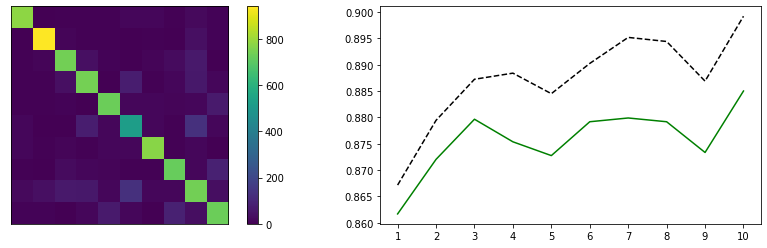

In [15]:
net = Net(loss=CrossEntropyLoss(), optimizer=GD(), adaptive_lr=True)
net.add(
    Linear(784, 10),
    Softmax()
)

train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.000001, steps=10)

Функция квадратичной ошибки допускает более долгое обучения и сильно зависит от начальных весов, приводя к результату от 30%, до 90%

Initial loss=57089.2503, accuracy=0.1369
Final loss=35683.2040, accuracy=0.4662
Test loss=8998.1886, accuracy=0.4619
Elapsed time: 44.22s


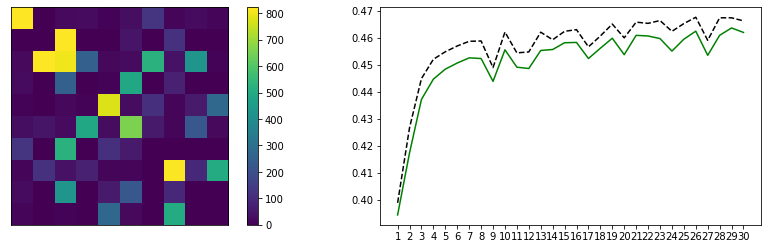

In [16]:
net = Net(loss=MeanSquareLoss(), optimizer=GD())
net.add(
    Linear(784, 10),
    Softmax()
)

train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.00001, steps=30)

Использование разных оптимизаторов. При фиксированном количестве эпох лучший результат получается при использовании RMSProp, затем градиентного спуска и Adagrad, наконец импульсного градиентного спуска

У первых двух наблюдается бо́льшая разница между точностью на тренировочных и тестовых данных

Initial loss=101.6535, accuracy=0.0869
Final loss=4.0072, accuracy=0.8374
Test loss=4.3457, accuracy=0.8317
Elapsed time: 11.86s


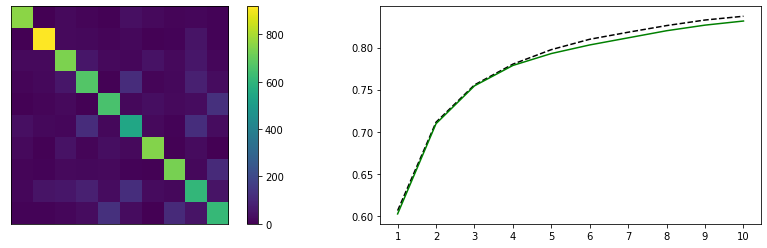

Initial loss=93.4281, accuracy=0.1168
Final loss=2.7271, accuracy=0.8828
Test loss=3.0064, accuracy=0.8765
Elapsed time: 9.63s


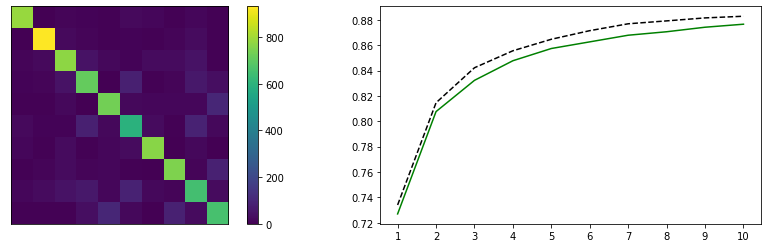

Initial loss=86.0424, accuracy=0.1498
Final loss=2.1682, accuracy=0.8906
Test loss=2.6407, accuracy=0.8776
Elapsed time: 8.56s


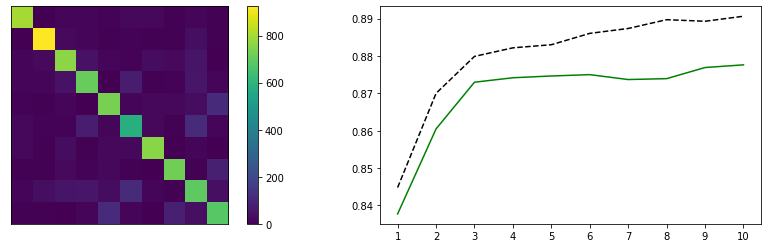

Initial loss=83.5741, accuracy=0.0901
Final loss=1.4638, accuracy=0.8867
Test loss=1.8186, accuracy=0.8783
Elapsed time: 7.73s


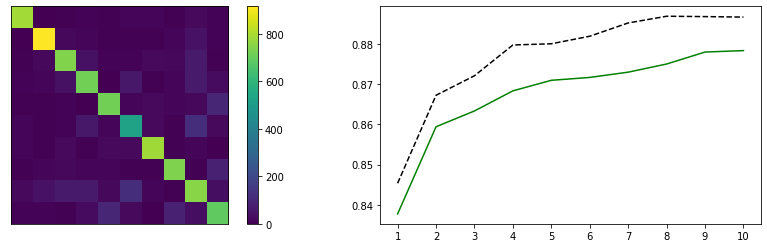

In [17]:
net = Net(loss=CrossEntropyLoss(), optimizer=NAG())
net.add(
    Linear(784, 10),
    Softmax()
)
train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.00007, steps=10)

net = Net(loss=CrossEntropyLoss(), optimizer=Adagrad())
net.add(
    Linear(784, 10),
    Softmax()
)
train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.00007, steps=10)

net = Net(loss=CrossEntropyLoss(), optimizer=RMSProp())
net.add(
    Linear(784, 10),
    Softmax()
)
train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.00007, steps=10)

net = Net(loss=CrossEntropyLoss(), optimizer=GD())
net.add(
    Linear(784, 10),
    Softmax()
)
train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.00007, steps=10)

Лучший результат - CrossEntropyLoss + Adagrad (или RMSProp) - 88%

Initial loss=81.5025, accuracy=0.0810
Final loss=2.4136, accuracy=0.8901
Test loss=2.6849, accuracy=0.8854
Elapsed time: 17.86s


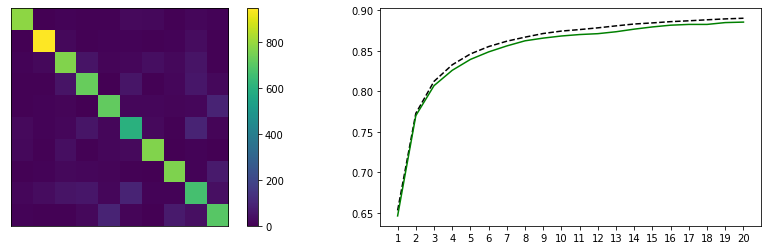

In [18]:
net = Net(loss=CrossEntropyLoss(), optimizer=Adagrad())
net.add(
    Linear(784, 10),
    Softmax()
)
train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.00005, steps=20)

### Многослойная сеть

При увеличении размера второго слоя увеличивается точность, но вместе с ней и переобучение. Остановимся на 200 нейронах

Initial loss=2.5063, accuracy=0.0948
Final loss=1.0072, accuracy=0.7630
Test loss=1.0202, accuracy=0.7568
Elapsed time: 31.88s


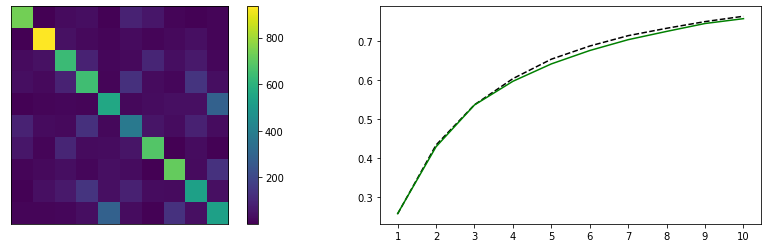

In [19]:
net = Net(loss=CrossEntropyLoss(), optimizer=GD())
net.add(
    Linear(784, 200),
    Tanh(),
    Linear(200, 10),
    Softmax()
)
train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.0001, steps=10)

Сигмоида требует большего обучения, Softplus и ReLU показывают сходные между собой результаты лучше тангенса

Initial loss=2.4829, accuracy=0.1006
Final loss=1.6024, accuracy=0.6781
Test loss=1.6023, accuracy=0.6814
Elapsed time: 35.39s


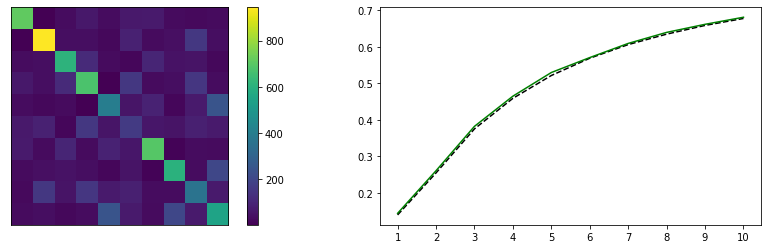

Initial loss=44.5394, accuracy=0.0998
Final loss=0.3704, accuracy=0.9395
Test loss=0.6583, accuracy=0.9096
Elapsed time: 39.77s


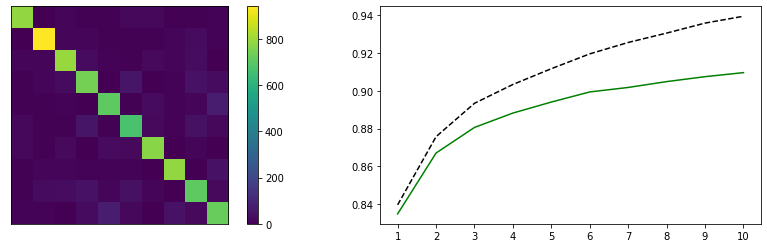

Initial loss=50.0840, accuracy=0.1309
Final loss=0.3961, accuracy=0.9361
Test loss=0.7098, accuracy=0.9087
Elapsed time: 31.40s


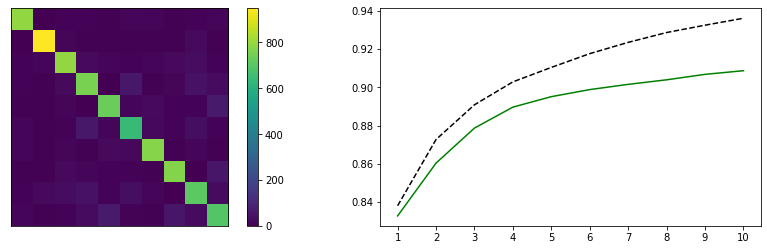

In [20]:
net = Net(loss=CrossEntropyLoss(), optimizer=GD())
net.add(
    Linear(784, 200),
    Sigmoid(),
    Linear(200, 10),
    Softmax()
)
train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.0001, steps=10)

net = Net(loss=CrossEntropyLoss(), optimizer=GD())
net.add(
    Linear(784, 200),
    SoftPlus(),
    Linear(200, 10),
    Softmax()
)
train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.0001, steps=10)

net = Net(loss=CrossEntropyLoss(), optimizer=GD())
net.add(
    Linear(784, 200),
    ReLU(),
    Linear(200, 10),
    Softmax()
)
train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.0001, steps=10)

Наилучшие варианты:

RMSProp + ReLU - 96%, при этом точность на обучающих данных приближается к 100%

Initial loss=55.6679, accuracy=0.1090
Final loss=0.0282, accuracy=0.9950
Test loss=0.5349, accuracy=0.9651
Elapsed time: 77.10s


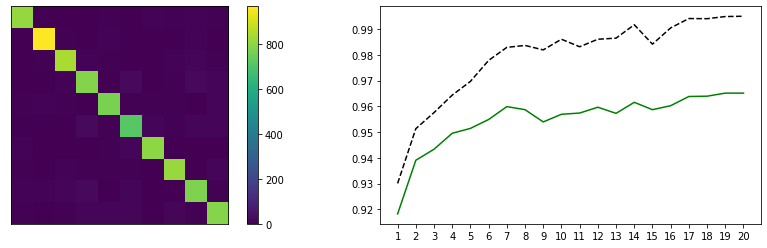

In [21]:
net = Net(loss=CrossEntropyLoss(), optimizer=RMSProp())
net.add(
    Linear(784, 200),
    ReLU(),
    Linear(200, 10),
    Softmax()
)

train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.0001, steps=20)

Adagrad + ReLU - 95%

Initial loss=35.7376, accuracy=0.1288
Final loss=0.0663, accuracy=0.9888
Test loss=0.4998, accuracy=0.9542
Elapsed time: 79.03s


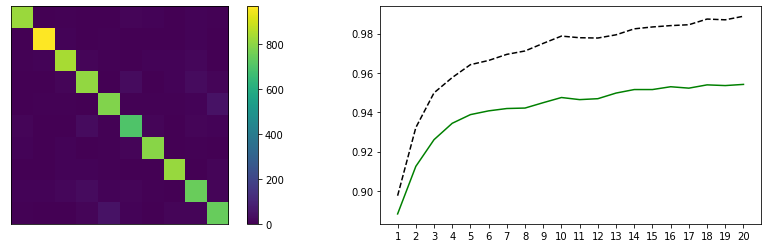

In [22]:
net = Net(loss=CrossEntropyLoss(), optimizer=Adagrad())
net.add(
    Linear(784, 200),
    ReLU(),
    Linear(200, 10),
    Softmax()
)

train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.0001, steps=20)

Добавление третьего слоя немного увеличивает точность, оставляя те же проблемы

Initial loss=22.3465, accuracy=0.1348
Final loss=0.0049, accuracy=0.9990
Test loss=0.2711, accuracy=0.9696
Elapsed time: 89.67s


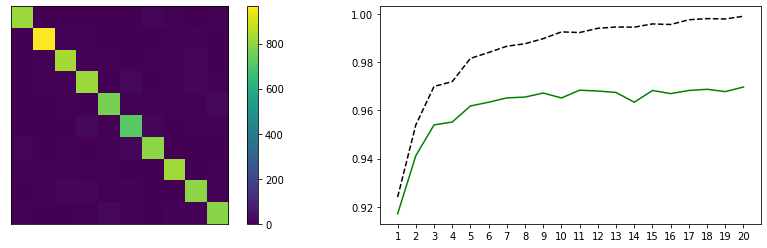

In [23]:
net = Net(loss=CrossEntropyLoss(), optimizer=RMSProp())
net.add(
    Linear(784, 200),
    ReLU(),
    Linear(200, 100),
    ReLU(),
    Linear(100, 10),
    Softmax()
)

train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.0001, steps=20)

Initial loss=17.2111, accuracy=0.1060
Final loss=0.0160, accuracy=0.9962
Test loss=0.2844, accuracy=0.9611
Elapsed time: 85.61s


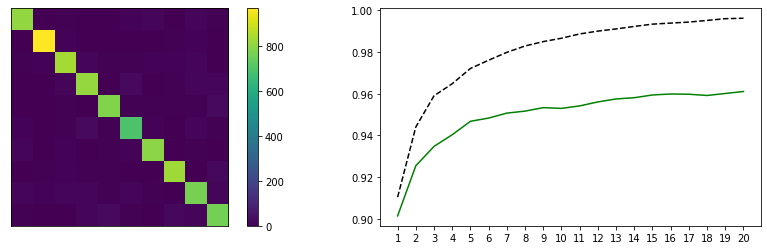

In [24]:
net = Net(loss=CrossEntropyLoss(), optimizer=Adagrad())
net.add(
    Linear(784, 200),
    ReLU(),
    Linear(200, 100),
    ReLU(),
    Linear(100, 10),
    Softmax()
)

train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.0001, steps=20)

## Fashion-MNIST

In [25]:
!curl -o test-images.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-images-idx3-ubyte.gz
!curl -o test-labels.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-labels-idx1-ubyte.gz
!curl -o train-images.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/train-images-idx3-ubyte.gz
!curl -o train-labels.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/train-labels-idx1-ubyte.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4318k  100 4318k    0     0  13.6M      0 --:--:-- --:--:-- --:--:-- 13.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5148  100  5148    0     0  31200      0 --:--:-- --:--:-- --:--:-- 31200
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25.1M  100 25.1M    0     0  39.1M      0 --:--:-- --:--:-- --:--:-- 39.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29515  100 29515    0     0   119k      0 --:--:-- --:--:-- --:--:--  119k


In [26]:
with gzip.open("test-labels.gz", "rb") as gz:
    fm_test_labels = np.frombuffer(gz.read(), dtype=np.uint8, offset=8)
with gzip.open("test-images.gz", "rb") as gz:
    fm_test_data = np.frombuffer(gz.read(), dtype=np.uint8, offset=16).reshape(len(fm_test_labels), 784)
    
with gzip.open("train-labels.gz", "rb") as gz:
    fm_train_labels = np.frombuffer(gz.read(), dtype=np.uint8, offset=8)
with gzip.open("train-images.gz", "rb") as gz:
    fm_train_data = np.frombuffer(gz.read(), dtype=np.uint8, offset=16).reshape(len(fm_train_labels), 784)
    
print(fm_train_data.shape, fm_test_data.shape)

(60000, 784) (10000, 784)


### Однослойные сети

Наискорейший градиентный спуск - точность 78% за 4-5 минут обучения

Initial loss=99.3553, accuracy=0.0691
Final loss=2.8558, accuracy=0.8053
Test loss=3.3707, accuracy=0.7880
Elapsed time: 424.37s


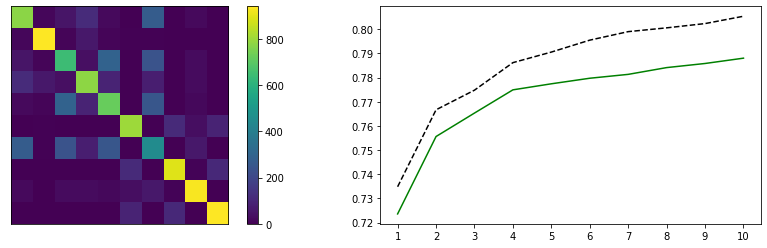

In [27]:
net = Net(loss=CrossEntropyLoss(), optimizer=GD(), adaptive_lr=True)
net.add(
    Linear(784, 10),
    Softmax()
)

train_and_plot(net, fm_train_data, fm_train_labels, fm_test_data, fm_test_labels, batch_size=100, lr=0.0000001, steps=10)

Adagrad - та же точность даже при том же числе эпох, с потенциальной возможностью увеличения их числа

Initial loss=113.0193, accuracy=0.1473
Final loss=4.4454, accuracy=0.7883
Test loss=5.0918, accuracy=0.7679
Elapsed time: 16.11s


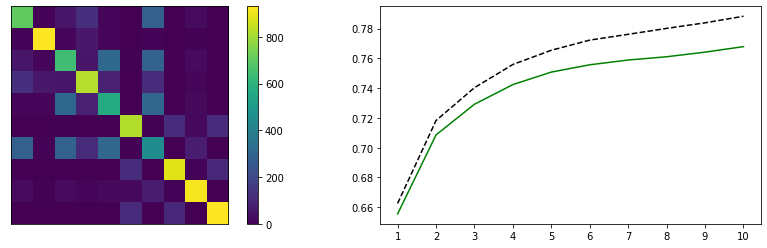

In [28]:
net = Net(loss=CrossEntropyLoss(), optimizer=Adagrad())
net.add(
    Linear(784, 10),
    Softmax()
)

train_and_plot(net, fm_train_data, fm_train_labels, fm_test_data, fm_test_labels, batch_size=100, lr=0.00004, steps=10)

### Двуслойные сети

Эмпирическим путем установлено, что оптимальным числом нейронов во втором слое является 90

Лучший результат - Adagrad + ReLU - 84%

Initial loss=40.8155, accuracy=0.0754
Final loss=1.1900, accuracy=0.8630
Test loss=1.6404, accuracy=0.8392
Elapsed time: 74.75s


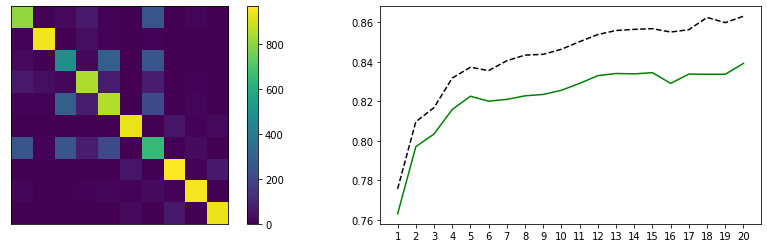

In [29]:
net = Net(loss=CrossEntropyLoss(), optimizer=Adagrad())
net.add(
    Linear(784, 90),
    ReLU(),
    Linear(90, 10),
    Softmax()
)

train_and_plot(net, fm_train_data, fm_train_labels, fm_test_data, fm_test_labels, batch_size=100, lr=0.0001, steps=20)

RMSProp + ReLU - немного хуже, 83%

Initial loss=49.8265, accuracy=0.1328
Final loss=0.6282, accuracy=0.8654
Test loss=0.8573, accuracy=0.8376
Elapsed time: 76.78s


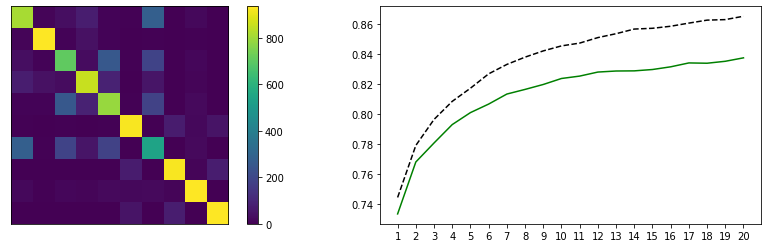

In [30]:
net = Net(loss=CrossEntropyLoss(), optimizer=RMSProp())
net.add(
    Linear(784, 90),
    ReLU(),
    Linear(90, 10),
    Softmax()
)

train_and_plot(net, fm_train_data, fm_train_labels, fm_test_data, fm_test_labels, batch_size=100, lr=0.00001, steps=20)

### Трехслойные сети

Оптимальная конфигурация: 784 - 90 - 80 - 10

Adagrad или RMSProp - 85%

Initial loss=33.2095, accuracy=0.0892
Final loss=0.5045, accuracy=0.8753
Test loss=0.7716, accuracy=0.8440
Elapsed time: 85.79s


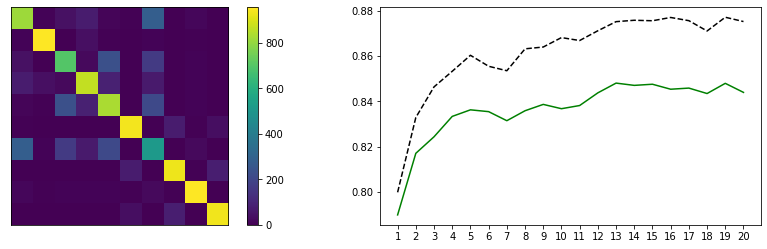

In [31]:
net = Net(loss=CrossEntropyLoss(), optimizer=Adagrad())
net.add(
    Linear(784, 90),
    ReLU(),
    Linear(90, 80),
    ReLU(),
    Linear(80, 10),
    Softmax()
)

train_and_plot(net, fm_train_data, fm_train_labels, fm_test_data, fm_test_labels, batch_size=100, lr=0.0001, steps=20)

Initial loss=27.2933, accuracy=0.0445
Final loss=0.4758, accuracy=0.8797
Test loss=0.7300, accuracy=0.8491
Elapsed time: 88.56s


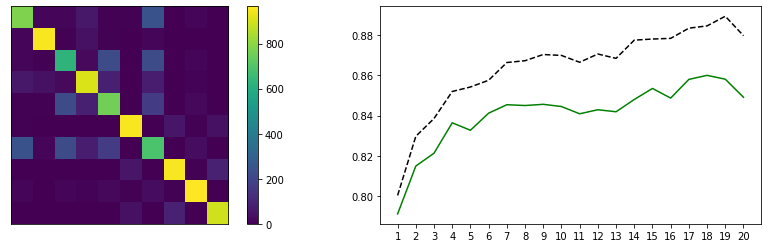

In [32]:
net = Net(loss=CrossEntropyLoss(), optimizer=RMSProp())
net.add(
    Linear(784, 90),
    ReLU(),
    Linear(90, 80),
    ReLU(),
    Linear(80, 10),
    Softmax()
)

train_and_plot(net, fm_train_data, fm_train_labels, fm_test_data, fm_test_labels, batch_size=100, lr=0.00004, steps=20)

Дальнейшее увеличение числа слоев ведет к незначительному увеличению точности. При этом конфигурации, в которых каждый следующий слой на 10 меньше предыдущего по прежнему остаются оптимальными. RMSProp начинает уступать Adagrad

Initial loss=17.0960, accuracy=0.0621
Final loss=0.4360, accuracy=0.8767
Test loss=0.6249, accuracy=0.8476
Elapsed time: 97.80s


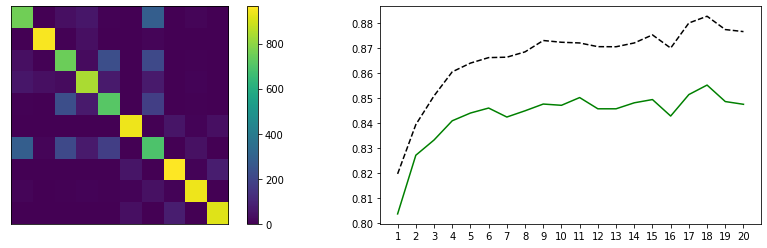

In [33]:
net = Net(loss=CrossEntropyLoss(), optimizer=Adagrad())
net.add(
    Linear(784, 90),
    ReLU(),
    Linear(90, 80),
    ReLU(),
    Linear(80, 70),
    ReLU(),
    Linear(70, 10),
    Softmax()
)

train_and_plot(net, fm_train_data, fm_train_labels, fm_test_data, fm_test_labels, batch_size=100, lr=0.0001, steps=20)

Initial loss=7.3812, accuracy=0.1242
Final loss=0.3524, accuracy=0.8888
Test loss=0.5006, accuracy=0.8616
Elapsed time: 108.63s


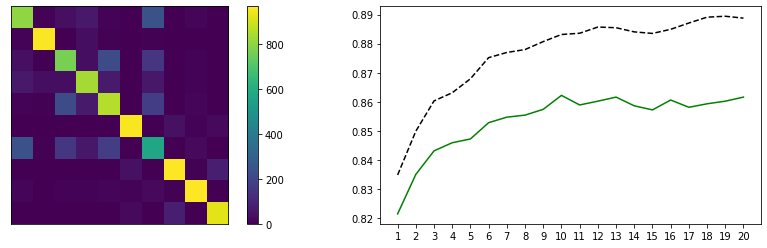

In [34]:
net = Net(loss=CrossEntropyLoss(), optimizer=Adagrad())
net.add(
    Linear(784, 90),
    ReLU(),
    Linear(90, 80),
    ReLU(),
    Linear(80, 70),
    ReLU(),
    Linear(70, 60),
    ReLU(),
    Linear(60, 10),
    Softmax()
)

train_and_plot(net, fm_train_data, fm_train_labels, fm_test_data, fm_test_labels, batch_size=100, lr=0.0001, steps=20)

Initial loss=3.1478, accuracy=0.1065
Final loss=0.3563, accuracy=0.8823
Test loss=0.4956, accuracy=0.8571
Elapsed time: 115.98s


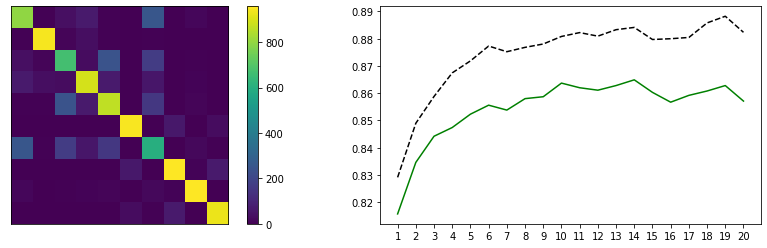

In [35]:
net = Net(loss=CrossEntropyLoss(), optimizer=Adagrad())
net.add(
    Linear(784, 90),
    ReLU(),
    Linear(90, 80),
    ReLU(),
    Linear(80, 70),
    ReLU(),
    Linear(70, 60),
    ReLU(),
    Linear(60, 50),
    ReLU(),
    Linear(50, 10),
    Softmax()
)

train_and_plot(net, fm_train_data, fm_train_labels, fm_test_data, fm_test_labels, batch_size=100, lr=0.0001, steps=20)